## Some standard imports of libriaries 

In [1]:
import pandas as pd
from pandas.io.json import build_table_schema
from pandas.plotting import scatter_matrix
import seaborn as sns
import numpy as np
import scipy as sp
import os
import xgboost as xgb
import visualization as vis
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

DIR_PATH = './'

## Columns/features currently in use

In [47]:
train  = pd.read_csv("clean_train_chase.csv")
test = pd.read_csv("clean_test_chase.csv")
print train.columns.values
print 40 * '*'
print test.columns.values

['id' 'quarter' 'timestamp' 'price_doc' 'kremlin_km' 'full_sq' 'life_sq'
 'floor' 'max_floor' 'sub_area' 'okurg_district']
****************************************
['id' 'timestamp' 'kremlin_km' 'full_sq' 'life_sq' 'kitch_sq' 'floor'
 'max_floor' 'build_year' 'num_room' 'state' 'material' 'sub_area'
 'okurg_district']


In [48]:
train.head()

,id,quarter,timestamp,price_doc,kremlin_km,full_sq,life_sq,floor,max_floor,sub_area,okurg_district
0,1,Q3-11,2011-08-20,5850000,15.156211,43.0,28.120000,4.0,5.0,Bibirevo,North Eastern
1,2,Q3-11,2011-08-23,6000000,8.698054,34.0,19.000000,3.0,9.0,Nagatinskij Zaton,Southern
2,3,Q3-11,2011-08-27,5700000,9.067885,43.0,29.000000,2.0,5.0,Tekstil'shhiki,South Eastern
3,4,Q3-11,2011-09-01,13100000,19.487005,89.0,67.522222,9.0,17.0,Mitino,North Western
4,5,Q3-11,2011-09-05,16331452,2.578671,77.0,70.777778,4.0,8.0,Basmannoe,Central


## The datatypes for each column

In [49]:
g = train.columns.to_series().groupby(train.dtypes).groups
g

{dtype('int64'): Index([u'id', u'price_doc'], dtype='object'),
 dtype('float64'): Index([u'kremlin_km', u'full_sq', u'life_sq', u'floor', u'max_floor'], dtype='object'),
 dtype('O'): Index([u'quarter', u'timestamp', u'sub_area', u'okurg_district'], dtype='object')}

In [50]:
print train.shape
print test.shape

(29098, 11)
(7662, 14)


In [51]:
## some simple feauture engineering from Shu. 
train.loc[:, 'log_price_doc'] = np.log(train['price_doc'] + 1)

train.loc[:, 'year'] =  train.loc[:,'timestamp'].apply(lambda x: x[0:4])
train.loc[:, 'month'] =  train.loc[:, 'timestamp'].apply(lambda x: x[5:7])
test.loc[:, 'year'] = test.loc[:, 'timestamp'].apply(lambda x: x[0:4])
test.loc[:, 'month'] = test.loc[:, 'timestamp'].apply(lambda x: x[0:4])


In [52]:
train.drop(["id", "timestamp", "price_doc","quarter"], axis=1, inplace= True)
test.drop(["id", "timestamp"], axis =1, inplace=True)

In [53]:
print train.columns.values
print 40 * '*'
print test.columns.values

['quarter' 'kremlin_km' 'full_sq' 'life_sq' 'floor' 'max_floor' 'sub_area'
 'okurg_district' 'log_price_doc' 'year' 'month']
****************************************
['kremlin_km' 'full_sq' 'life_sq' 'kitch_sq' 'floor' 'max_floor'
 'build_year' 'num_room' 'state' 'material' 'sub_area' 'okurg_district'
 'year' 'month']


In [7]:
from sklearn import model_selection, preprocessing
for f in train.columns:
    if train[f].dtype=='object':
        print(f)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[f].values.astype('str')))
        train[f] = lbl.transform(list(train[f].values.astype('str')))

product_type
sub_area
okurg_district
year
month


In [8]:
from sklearn import model_selection, preprocessing
for f in test.columns:
    if test[f].dtype=='object':
        print(f)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(test[f].values.astype('str')))
        test[f] = lbl.transform(list(test[f].values.astype('str')))

product_type
sub_area
okurg_district
year
month


In [9]:
print train.columns.values
print("The number of columns after slight feature engineering is {:.2f}".format(len(list(train.columns.values))))

['full_sq' 'floor' 'max_floor' 'product_type' 'sub_area' 'metro_min_walk'
 'kindergarten_km' 'park_km' 'kremlin_km' 'oil_chemistry_km'
 'nuclear_reactor_km' 'big_market_km' 'market_shop_km'
 'detention_facility_km' 'public_healthcare_km' 'university_km'
 'workplaces_km' 'preschool_km' 'big_church_km' 'okurg_district'
 'pop_density' 'elder_ratio' 'youth_ratio' 'floor_ratio' 'year' 'month'
 'oil_urals' 'cpi' 'eurrub' 'average_provision_of_build_contract_moscow'
 'micex' 'mortgage_rate' 'rent_price_4+room_bus' 'sd_oil_yearly'
 'sd_cpi_yearly' 'sd_eurrub_yearly' 'sd_micex_yearly' 'sd_mortgage_yearly'
 'sd_rent_yearly' 'log_price_doc']
The number of columns after slight feature engineering is 40.00


In [10]:
g = train.columns.to_series().groupby(train.dtypes).groups
g# The year is a float and maybe it should be a categorical variable. 

{dtype('int64'): Index([u'full_sq', u'floor', u'product_type', u'sub_area', u'okurg_district',
        u'year', u'month'],
       dtype='object'),
 dtype('float64'): Index([u'max_floor', u'metro_min_walk', u'kindergarten_km', u'park_km',
        u'kremlin_km', u'oil_chemistry_km', u'nuclear_reactor_km',
        u'big_market_km', u'market_shop_km', u'detention_facility_km',
        u'public_healthcare_km', u'university_km', u'workplaces_km',
        u'preschool_km', u'big_church_km', u'pop_density', u'elder_ratio',
        u'youth_ratio', u'floor_ratio', u'oil_urals', u'cpi', u'eurrub',
        u'average_provision_of_build_contract_moscow', u'micex',
        u'mortgage_rate', u'rent_price_4+room_bus', u'sd_oil_yearly',
        u'sd_cpi_yearly', u'sd_eurrub_yearly', u'sd_micex_yearly',
        u'sd_mortgage_yearly', u'sd_rent_yearly', u'log_price_doc'],
       dtype='object')}

In [21]:
# model_features  = ['full_sq', 'life_sq', 'floor', 'build_year',
#                    'max_floor', 'kitch_sq', 'num_room', 'state', 'kindergarten_km',
#                    'green_zone_km', 'school_km', 'metro_min_avto',
#                    'public_healthcare_km', 'industrial_km',
#                    'metro_min_walk', 'railroad_km', 'swim_pool_km', 'material',
#                    'sub_area_le']

# model_features_noMissing = ['full_sq','kindergarten_km','green_zone_km', 'school_km', 'metro_min_avto',
#                             'public_healthcare_km', 'industrial_km', 'railroad_km', 'swim_pool_km','sub_area_le',
#                             'year','month']

model_features_noMissing = ['full_sq', 
                            'floor', 
                            'max_floor', 
                            'product_type', 
                            'sub_area',
                            'metro_min_walk',
                            'kindergarten_km',
                            'park_km',
                            'kremlin_km',
                            'oil_chemistry_km',
                            'nuclear_reactor_km',
                            'big_market_km',
                            'market_shop_km',
                            'detention_facility_km',
                            'public_healthcare_km',
                            'university_km',
                            'workplaces_km',
                            'preschool_km',
                            'big_church_km',
                            'okurg_district',
                            'pop_density',
                            'elder_ratio',
                            'youth_ratio',
                            'floor_ratio',
                            'year',
                            'month',
                            'oil_urals',
                            'cpi',
                            'eurrub',
                            'average_provision_of_build_contract_moscow',
                            'micex', 'mortgage_rate', 'rent_price_4+room_bus', 'sd_oil_yearly',
                            'sd_cpi_yearly', 'sd_eurrub_yearly', 'sd_micex_yearly', 'sd_mortgage_yearly',
                            'sd_rent_yearly']
# top 8
#f0, f8, f6, f5, f11, f10, f14, f16
model_features_noMissing = ['full_sq', #0
                            'metro_min_walk', #5
                            'kindergarten_km', #6
                            'kremlin_km', #8
                            'nuclear_reactor_km', # 10
                            'big_market_km', #11
                            'public_healthcare_km', # 14
                            'workplaces_km',#16
                           ]


'full_sq'

(30142, 8)
(30142,)
(7662, 8)


In [ ]:
X_train = train[model_features_noMissing].values
Y_train = train['log_price_doc'].values
X_test = test[model_features_noMissing].values

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)

In [22]:
print  train[model_features_noMissing].columns.values

['full_sq' 'metro_min_walk' 'kindergarten_km' 'kremlin_km'
 'nuclear_reactor_km' 'big_market_km' 'public_healthcare_km'
 'workplaces_km']


# Checking that we are no longer using missing data

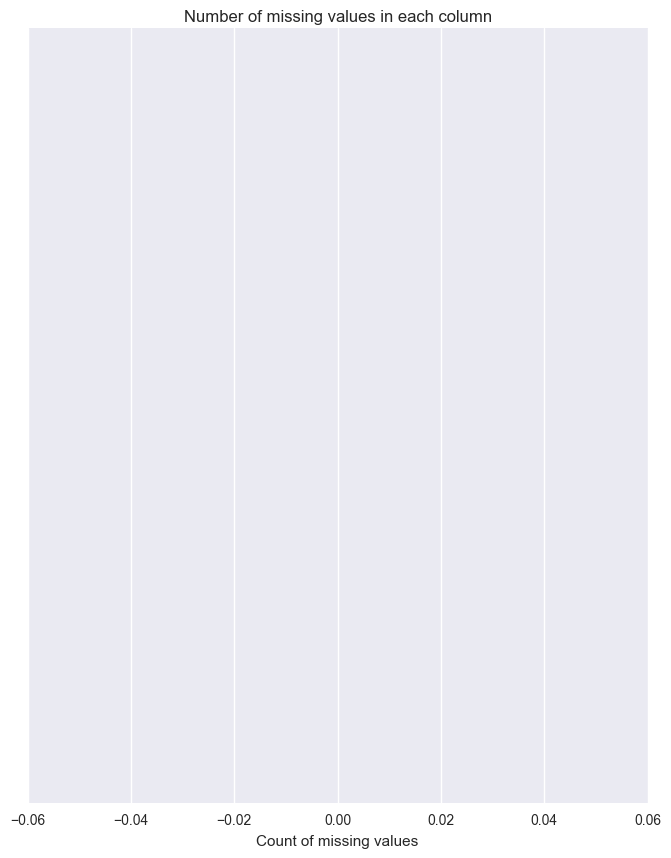

array([], dtype=object)

In [23]:
# list_of_num_features = ['floor', 'metro_min_walk', 'kindergarten_km', 'park_km',
#         'kremlin_km', 'oil_chemistry_km', 'nuclear_reactor_km',
#         'big_market_km', 'market_shop_km', 'detention_facility_km',
#         'public_healthcare_km', 'university_km', 'workplaces_km',
#         'preschool_km', 'big_church_km', 'oil_urals', 'cpi', 'ppi',
#         'eurrub', 'brent', 'average_provision_of_build_contract_moscow',
#         'micex', 'mortgage_rate', 'rent_price_4+room_bus', 'sd_oil_yearly',
#         'sd_cpi_yearly', 'sd_ppi_yearly', 'sd_eurrub_yearly',
#         'sd_brent_yearly', 'sd_micex_yearly', 'sd_mortgage_yearly',
#         'sd_rent_yearly', 'sq_metr', 'pop_density', 'elder_ratio',
#         'youth_ratio']

list_of_num_features =  ['full_sq', 
                            'floor', 
                            'max_floor', 
                            'product_type', 
                            'sub_area',
                            'metro_min_walk',
                            'kindergarten_km',
                            'park_km',
                            'kremlin_km',
                            'oil_chemistry_km',
                            'nuclear_reactor_km',
                            'big_market_km',
                            'market_shop_km',
                            'detention_facility_km',
                            'public_healthcare_km',
                            'university_km',
                            'workplaces_km',
                            'preschool_km',
                            'big_church_km',
                            'okurg_district',
                            'pop_density',
                            'elder_ratio',
                            'youth_ratio',
                            'floor_ratio',
                            'year',
                            'month',
                            'oil_urals',
                            'cpi',
                            'eurrub',
                            'average_provision_of_build_contract_moscow',
                            'micex', 'mortgage_rate', 'rent_price_4+room_bus', 'sd_oil_yearly',
                            'sd_cpi_yearly', 'sd_eurrub_yearly', 'sd_micex_yearly', 'sd_mortgage_yearly',
                            'sd_rent_yearly']

missing_df = train[list_of_num_features].isnull().sum(axis=0).reset_index()


missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count'] > 0]
ind = np.arange(missing_df.shape[0])
width =  0.9 
fig, ax = plt.subplots(figsize=(8,10))
rects = ax.barh(ind, missing_df.missing_count.values, color ='y')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()
missing_df.loc[:,'column_name'].values

## Modelling:
### Here we go! The first model of interest is the Random Forest. 
### We want to use this first, since we have't scaled the features (yet) and they don't require heavy tuning.
### Note: Will go back to use simple Decision Tree, because we want to have some representation of the decision making. BOOM!

### The important features to adjust are n_estimators, max_features, and max depth. For n_estimators larger is always better.  Smaller max_features reduces overfitting.

### Empirical good default values are max_features=n_features for regression problems




In [24]:
from sklearn.tree import DecisionTreeRegressor 
tree = DecisionTreeRegressor().fit(X_train, Y_train)

(array([   17.,    14.,   318.,   367.,   810.,  3278.,  2274.,   486.,
           84.,    14.]),
 array([ 12.46844076,  13.02773789,  13.58703502,  14.14633215,
         14.70562928,  15.2649264 ,  15.82422353,  16.38352066,
         16.94281779,  17.50211492,  18.06141205]),
 <a list of 10 Patch objects>)

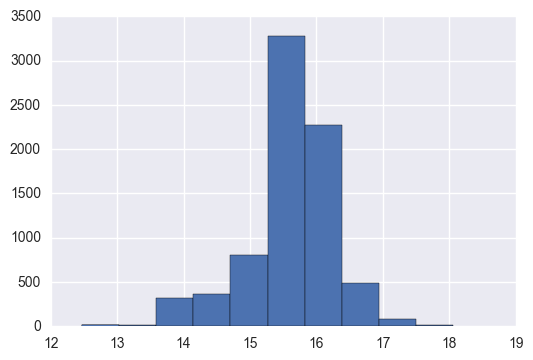

In [25]:
log_y_test = tree.predict(X_test)
plt.hist(log_y_test)

In [26]:
print("The R^2 on the training set:  {:.6f}".format(tree.score(X_train, Y_train)))

The R^2 on the training set:  0.957587


In [28]:
from sklearn.ensemble import RandomForestRegressor

In [29]:
n_features = X_train.shape[1] # Random Forest cannot handle missing data
print n_features
forest = RandomForestRegressor(n_estimators=600, random_state= 2, max_features=n_features)
forest.fit(X_train, Y_train) 


8


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
           oob_score=False, random_state=2, verbose=0, warm_start=False)

In [30]:
import math 
log_y_test = forest.predict(X_test)
log_y_test

array([ 16.06426923,  15.21584189,  15.58166778, ...,  14.90191561,
        15.0916952 ,  15.72553977])

(array([   60.,   248.,   896.,  2642.,  2315.,  1045.,   333.,    88.,
           26.,     9.]),
 array([ 14.19507983,  14.54246897,  14.88985811,  15.23724725,
         15.5846364 ,  15.93202554,  16.27941468,  16.62680383,
         16.97419297,  17.32158211,  17.66897125]),
 <a list of 10 Patch objects>)

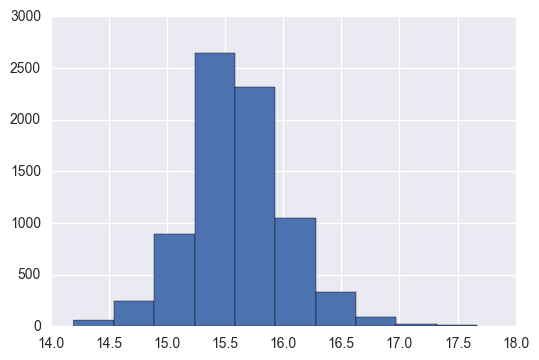

In [31]:
plt.hist(log_y_test)

In [32]:
print("The R^2 on the training set:  {:.6f}".format(forest.score(X_train, Y_train)))

The R^2 on the training set:  0.881989


## The R^2 on the training set:  0.878585 (only features with no missing data) 
## The R^2 on the training set:  0.911619 with the year and month added as features


In [33]:
y_pred = np.exp(log_y_test) - 1

In [34]:
submit = pd.DataFrame({'id': np.array(test.index)+30474, 'price_doc': y_pred})
submit.to_csv('submissionRF_05_25_17.csv', index=False)

# XGBoost

In [35]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
   'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 0
}



dtrain = xgb.DMatrix(X_train,Y_train)
dtest = xgb.DMatrix(X_test)

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False)

num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)



[0]	train-rmse:14.367	test-rmse:14.367
[50]	train-rmse:1.20751	test-rmse:1.21012
[100]	train-rmse:0.467767	test-rmse:0.484432
[150]	train-rmse:0.44952	test-rmse:0.474975
[200]	train-rmse:0.440562	test-rmse:0.473865
[250]	train-rmse:0.433204	test-rmse:0.473344
[300]	train-rmse:0.425772	test-rmse:0.472902
[350]	train-rmse:0.418756	test-rmse:0.472777


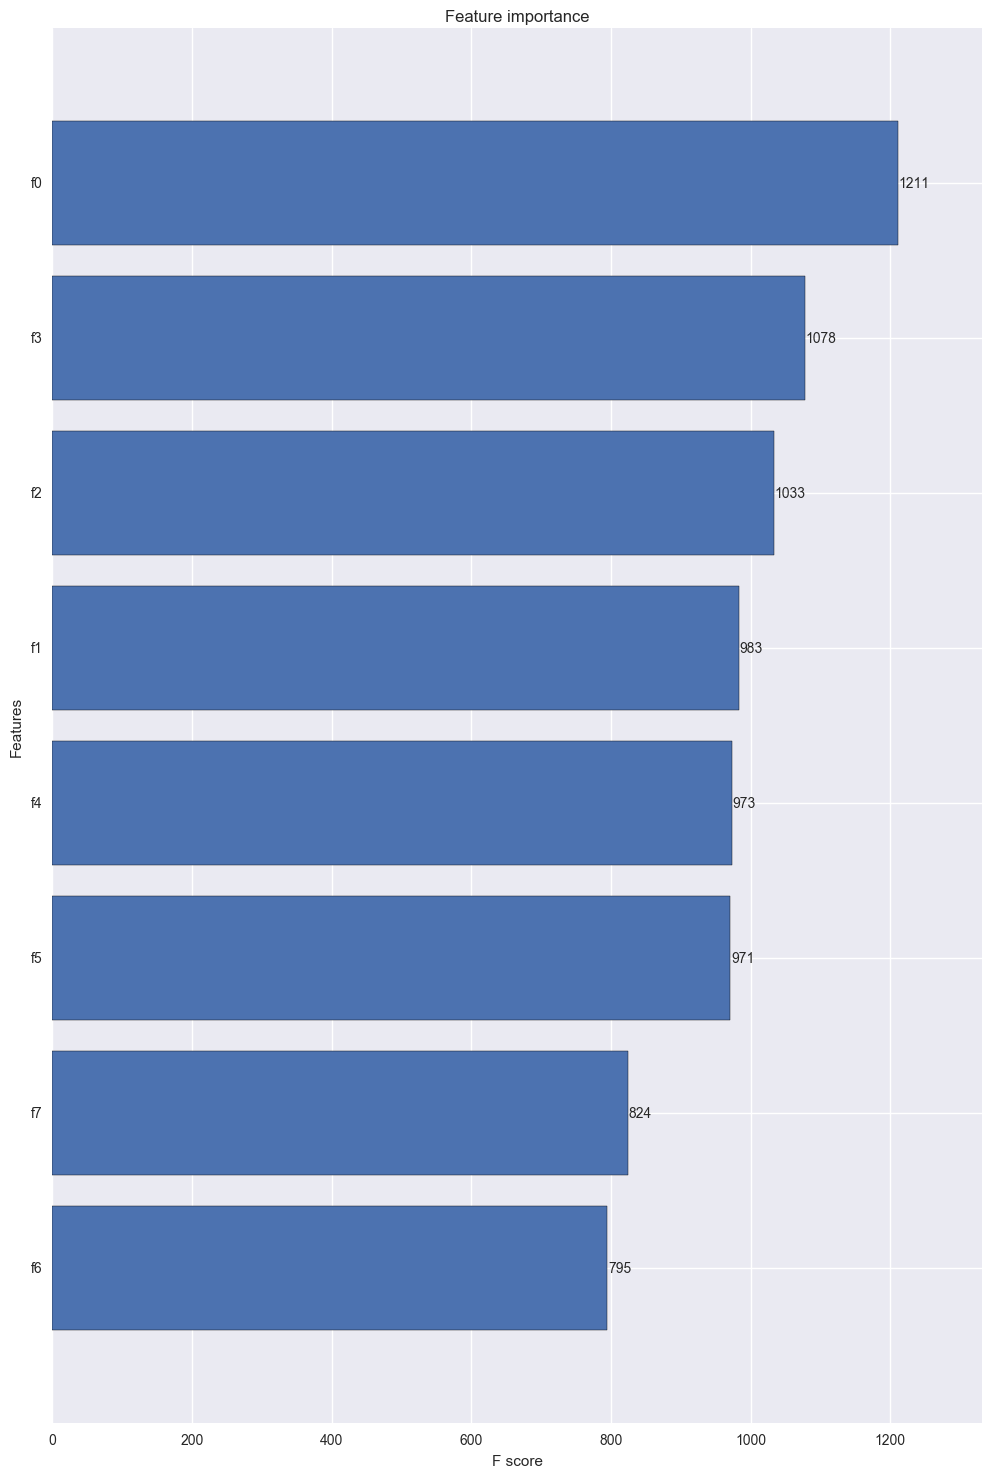

In [36]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=20, height=0.8, ax=ax)

#f0, f8, f6, f5, f11, f10, f14, f16
plt.show()

(array([  128.,   512.,  2102.,  2777.,  1370.,   527.,   151.,    65.,
           23.,     7.]),
 array([ 14.55560684,  14.8658514 ,  15.17609596,  15.48634052,
         15.79658508,  16.10682964,  16.4170742 ,  16.72731876,
         17.03756332,  17.34780788,  17.65805244]),
 <a list of 10 Patch objects>)

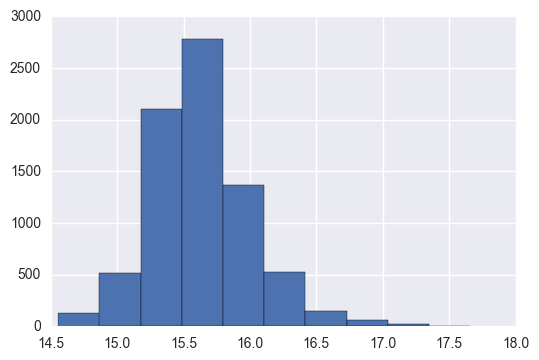

In [38]:
y_predict = model.predict(dtest)
plt.hist(y_predict)

In [39]:
np.exp(y_predict) - 1 

array([ 10281108.  ,   4247753.  ,   8158000.5 , ...,   2802053.25,
         3539301.  ,   6404240.5 ], dtype=float32)

In [40]:
y_predict_new =  np.exp(y_predict) - 1
output = pd.DataFrame({'id': np.array(test.index)+30474, 'price_doc': y_predict_new})

In [41]:
output.shape

(7662, 2)

In [42]:
output.to_csv('submission_xgb_05_25_17.csv', index=False)

In [45]:
# Lasso Regression: Do we need CV for feature selection

## Ridge Regression:  
### L2. So we are wanting learn two things from this model. 1) Implement a cross-validation 5-fold method to determine the coffiecient lambda/alpha. 2) Scale that data down!  We need to have all the features on the same scale. Let's get to work! 

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler # All the features will be between 0 and 1 

In [44]:
#Currently we don't have that many variables 12 and we are probably not overfitting. 

#Scaling it!
scaler = MinMaxScaler() 
scaler.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [45]:
X_train_scaled = scaler.transform(X_train)

In [46]:
print("transformed shape {}".format(X_train_scaled.shape))
print("per-feature minimum before scaling {}".format(X_train.min(axis=0)))
print("per-feature maximum before scaling {}".format(X_train.max(axis=0)))
print 20 * '-' + "Some Day I'm going to Scale that Mountain!" + 20 * '-'
print("per-feature minimum after scaling {}".format(X_train_scaled.min(axis=0)))
print("per-feature maximum after scaling {}".format(X_train_scaled.max(axis=0)))
print "Scaled it!"
X_test_scaled = scaler.transform(X_test)

transformed shape (30142, 39)
per-feature minimum before scaling [  1.00000000e+01   1.00000000e+00   1.00000000e+00   0.00000000e+00
   0.00000000e+00   8.00000000e-02   4.70000000e-04   3.73717500e-03
   7.28965530e-02   5.10709937e-01   3.09810795e-01   6.61366220e-01
   3.84714600e-03   4.12270840e-02   2.65695100e-03   3.13000000e-04
   4.96552170e-02   2.91622490e-02   4.07187200e-03   0.00000000e+00
   1.53000000e-05   1.14854244e-01   7.80066100e-02   2.70270270e-02
   0.00000000e+00   0.00000000e+00   4.63414000e+01   3.53000000e+02
   3.84337000e+01   5.96000000e+00   1.23743000e+03   1.14000000e+01
   1.00080000e+02   3.80890499e+00   5.08069198e+00   7.67611131e-01
   6.74001118e+01   2.20399655e-01   1.05679591e+01]
per-feature maximum before scaling [  4.07000000e+02   4.40000000e+01   5.70000000e+01   1.00000000e+00
   1.44000000e+02   7.11215806e+02   2.90857738e+01   4.73515383e+01
   7.07387691e+01   7.04134343e+01   6.42569575e+01   5.95016484e+01
   4.11036507e+01  

In [47]:
# prepare a range of alpha values to test
param_grid = {'alpha': [100,10,1,0.1,0.01,0.001,0.0001,0]}
grid =  GridSearchCV(Ridge(), param_grid, cv =5)
grid.fit(X_train_scaled,Y_train)

/Users/yogadude/anaconda/lib/python2.7/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.72013382369e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)
/Users/yogadude/anaconda/lib/python2.7/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.22546099646e-18
  ' condition number: {}'.format(rcond), RuntimeWarning)
/Users/yogadude/anaconda/lib/python2.7/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.95560119593e-18
  ' condition number: {}'.format(rcond), RuntimeWarning)
/Users/yogadude/anaconda/lib/python2.7/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-co

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [48]:
print("Best parameters: {}".format(grid.best_params_))
print("Best cross-validation score: {:.3f}".format(grid.best_score_))

Best parameters: {'alpha': 10}
Best cross-validation score: 0.291


In [49]:
results = pd.DataFrame(grid.cv_results_)
results # change this to show the entire DF 

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.038269,0.000823,0.248858,0.266785,100,{u'alpha': 100},2,0.205252,0.282399,0.172722,...,0.193065,0.285271,0.263395,0.253101,0.409877,0.224054,0.009392,0.000281,0.085963,0.024887
1,0.025485,0.000618,0.291494,0.350426,10,{u'alpha': 10},1,0.271690,0.366014,0.218456,...,0.267092,0.369698,0.364325,0.337894,0.335924,0.301386,0.001009,0.000139,0.052155,0.027892
2,0.024134,0.000558,0.139985,0.356210,1,{u'alpha': 1},8,0.270878,0.371932,0.211609,...,0.271699,0.375576,0.371342,0.343682,-0.425639,0.307270,0.000438,0.000008,0.287418,0.027822
3,0.026688,0.000689,0.154922,0.356430,0.1,{u'alpha': 0.1},7,0.268912,0.372182,0.210291,...,0.271424,0.375802,0.371934,0.343861,-0.347979,0.307591,0.002269,0.000108,0.256755,0.027776
4,0.028834,0.000822,0.168242,0.356434,0.01,{u'alpha': 0.01},6,0.268621,0.372186,0.210168,...,0.271365,0.375805,0.371995,0.343864,-0.280962,0.307600,0.001861,0.000196,0.230544,0.027774
5,0.024281,0.000570,0.169834,0.356434,0.001,{u'alpha': 0.001},5,0.268591,0.372186,0.210156,...,0.271359,0.375805,0.372001,0.343864,-0.272959,0.307600,0.000230,0.000023,0.227424,0.027774
6,0.023666,0.000583,0.169996,0.356434,0.0001,{u'alpha': 0.0001},4,0.268588,0.372186,0.210155,...,0.271358,0.375805,0.372002,0.343864,-0.272144,0.307600,0.000636,0.000082,0.227106,0.027774
7,0.024565,0.000692,0.170014,0.356434,0,{u'alpha': 0},3,0.268588,0.372186,0.210155,...,0.271358,0.375805,0.372002,0.343864,-0.272054,0.307600,0.001439,0.000155,0.227071,0.027774


In [50]:
print("The R^2 on the training set:  {:.6f}".format(grid.score(X_train_scaled, Y_train)))

The R^2 on the training set:  0.349773


In [51]:
log_y_test_L2 =grid.predict(X_test_scaled)
y_pred = np.exp(log_y_test_L2) - 1

(array([  5.40000000e+01,   3.10000000e+02,   3.34600000e+03,
          3.35300000e+03,   5.17000000e+02,   6.40000000e+01,
          1.10000000e+01,   4.00000000e+00,   2.00000000e+00,
          1.00000000e+00]),
 array([ 14.34349368,  14.80280323,  15.26211278,  15.72142233,
         16.18073188,  16.64004143,  17.09935098,  17.55866052,
         18.01797007,  18.47727962,  18.93658917]),
 <a list of 10 Patch objects>)

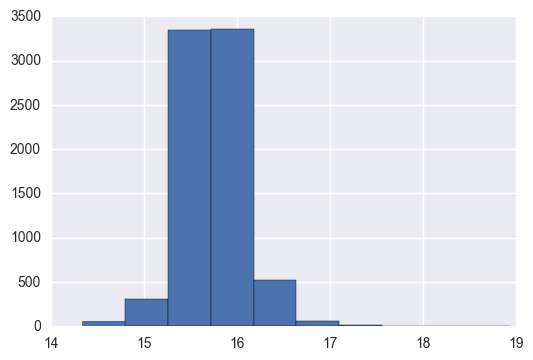

In [52]:
plt.hist(log_y_test_L2) # The finger from Ridge.  

# Can you throw me a Line? That's a Pipe.... line.
## So in this section we are just coming to terms with using a pipeline on our data. Let me see you work,work, work ...

In [53]:
from sklearn.pipeline import make_pipeline 
pipe  =  make_pipeline(MinMaxScaler(), Ridge())
param_grid = {'ridge__alpha': [100,10,1,0.1,0.01,0.001,0.0001,0]}
grid =  GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, Y_train)

/Users/yogadude/anaconda/lib/python2.7/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.88960407568e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)
/Users/yogadude/anaconda/lib/python2.7/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.03456854585e-18
  ' condition number: {}'.format(rcond), RuntimeWarning)
/Users/yogadude/anaconda/lib/python2.7/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.35514916176e-18
  ' condition number: {}'.format(rcond), RuntimeWarning)
/Users/yogadude/anaconda/lib/python2.7/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-co

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'ridge__alpha': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [54]:
print("Best Cross-validation RMS: {:.3f}".format(grid.best_score_))
#print("Test Best Score: {:.3f}".format(grid.score(X_test, Y_test)))
print("Best parameters: {}".format(grid.best_params_))

Best Cross-validation RMS: 0.170
Best parameters: {'ridge__alpha': 0}


# Wait! What? You Going Non-Linear On Me?! You Know it! 

In [73]:
from sklearn.preprocessing import PolynomialFeatures

In [35]:
## Don't Run this 
# pipe2 = make_pipeline(MinMaxScaler(), PolynomialFeatures(), Ridge())
# param_grid ={'polynomialfeatures__degree': [1,2,3],
#             'ridge__alpha': [100,10,1,0.1,0.01,0.001,0.0001,0]}
# grid = GridSearchCV(pipe2, param_grid=param_grid, cv=5, n_jobs=-1)
# grid.fit(X_train, Y_train)
